In [2]:
# -*- coding: utf-8 -*-
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

"""LSTM_Keystroke_Similarity
"""
import numpy as np
import pandas as pd
import random
import keras.backend as K
#import keras.utils as ku
from keras.models import *
from keras.layers import *
from keras.layers.embeddings import *
from keras.optimizers import Adadelta
from keras.optimizers import Adam
#from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
#from keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.utils import multi_gpu_model

np.random.seed(12345)

# Global Variables
HID_DIM = 128
SQUENCE_NUM = 70
VECTOR_UNIT = 5
VECTOR_LEN = SQUENCE_NUM * VECTOR_UNIT

# Create pairs
def create_pairs(df,user):
    all_pairs_list = []
    df_user = df[df['user'] == user]
    df_user_len = len(df_user)
    print('user_num_of_samples',df_user_len)
    for i in range(df_user_len):
        same_pair_list = []
        z1, z2 = sum(df_user.iloc[i, 2], []), sum(df_user.iloc[i, 2], [])
        same_pair_list.append(z1)
        same_pair_list.append(z2)
        same_pair_list.append(1.0)  # 同一用户样本标识1
        all_pairs_list.append(same_pair_list)
    return all_pairs_list


def process_data(pairs):
    keystroke1_data_list = []
    keystroke2_data_list = []
    label_list = []
    for i in range(len(pairs)):
        keystroke1_data = pad_sequences([pairs[i][0]], maxlen=VECTOR_LEN, dtype='float32', padding='post',
                                        truncating='post')
        keystroke2_data = pad_sequences([pairs[i][1]], maxlen=VECTOR_LEN, dtype='float32', padding='post',
                                        truncating='post')
        label = pairs[i][2]
        judge_nan_left = np.array(keystroke1_data[0])
        judge_nan_right = np.array(keystroke2_data[0])
        if np.any(np.isnan(judge_nan_left)) or np.any(np.isnan(judge_nan_right)):
            #print('judge_nan_left',judge_nan_left)
            #print('judge_nan_right',judge_nan_right)
            continue
        keystroke1_data_list.append(keystroke1_data[0])
        keystroke2_data_list.append(keystroke2_data[0])
        label_list.append(label)
        if np.any(np.isnan(judge_nan_left)):
            print('zc_nan')
    return np.array(keystroke1_data_list), np.array(keystroke2_data_list), np.array(label_list)


def Euclidean_distance(vectors):
    left, right = vectors
    #K.print_tensor(left,message='left')
    #K.print_tensor(right,message='right')
    sum_square = K.sum(K.square(left - right), axis=1, keepdims=True)
    #K.print_tensor(sum_square,message='Eucl_dis')
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def manhatan_distance(vector):
    left, right = vector
    return K.sum(K.abs(left-right),axis=1,keepdims=True)

def manhatan_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    margin = 1.5
    sqaure_pred = K.square(y_pred)
    #margin_square = K.square(K.maximum(K.abs(margin - y_pred), 0.0))
    margin_square = K.square(K.maximum(margin - y_pred, 0.0))
    return K.mean(y_true * sqaure_pred + (1.0 - y_true) * margin_square + 1e-10)

def accuracy(y_true, y_pred):  # Tensor上的操作
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 1.0, y_true.dtype)))

def create_base_network(dim):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=(SQUENCE_NUM, VECTOR_UNIT))
    mask = Masking(0)(input)
    bn_layer1 = BatchNormalization(name='bn_layer1')(mask)
    lstm_1 = LSTM(dim, activation='relu', kernel_initializer='random_uniform',bias_initializer='zeros',
                  return_sequences=True, name='lstm_layer1', recurrent_dropout=0.2)
    lstm_layer1 = lstm_1(bn_layer1)
    Dropout(lstm_layer1, 0.5)
    bn_layer2 = BatchNormalization(name='bn_layer2_input1')(lstm_layer1)
    lstm_2 = LSTM(dim, activation='relu', kernel_initializer='random_uniform',bias_initializer='zeros',
                  return_sequences=False, name='lstm_layer2', recurrent_dropout=0.2)
    lstm_layer2 = lstm_2(bn_layer2)


    return Model(input, lstm_layer2)

In [3]:
file_name = './5_subject_for_test.json'
#file_name = './five_tuple_vector_data.json'

df = pd.read_json(file_name)
user = 167184

data_pairs= create_pairs(df,user)
left,right,label = process_data(data_pairs)

num = left.shape[0]

left = left.reshape(num,70,5)
right = right.reshape(num,70,5)

base_network = create_base_network(HID_DIM)

input_left = Input(shape=(SQUENCE_NUM,VECTOR_UNIT))
input_right = Input(shape=(SQUENCE_NUM,VECTOR_UNIT))

processed_left = base_network(input_left)
processed_right = base_network(input_right)

distance = Lambda(Euclidean_distance,output_shape=eucl_dist_output_shape)([processed_left, processed_right])

model = Model([input_left, input_right], distance)
left_predict = Model([input_left, input_right],processed_left)

#model.load_weights('./model/Euclidean_distance_epochs_50batch_size_512_lr005_correct.h5')
model.load_weights('./model/last_680000/Euclidean_distance_epochs_50batch_size_512_lr00005_correct68000.h5')

model.summary()

user_num_of_samples 15
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 70, 5)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 70, 5)]      0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 128)          200724      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           mode

In [4]:
file_name = './5_subject_for_test.json'
#file_name = './five_tuple_vector_data.json'

df = pd.read_json(file_name)

user_list = [167184,290728,338404,382301,416965]




'''
colum_list = ['user','sess']
for i in range(128):
    colum_list += ['vector_'+str(i)]

data_frame = pd.DataFrame(columns = colum_list)
'''    
data_frame = None

for i,u in enumerate(user_list):    
    data_pairs= create_pairs(df,u)
    left,right,label = process_data(data_pairs)

    num = left.shape[0]

    left = left.reshape(num,70,5)
    right = right.reshape(num,70,5)

    base_network = create_base_network(HID_DIM)

    input_left = Input(shape=(SQUENCE_NUM,VECTOR_UNIT))
    input_right = Input(shape=(SQUENCE_NUM,VECTOR_UNIT))

    processed_left = base_network(input_left)
    processed_right = base_network(input_right)

    distance = Lambda(Euclidean_distance,output_shape=eucl_dist_output_shape)([processed_left, processed_right])

    model = Model([input_left, input_right], distance)
    left_predict = Model([input_left, input_right],processed_left)

    #model.load_weights('./model/Euclidean_distance_epochs_50batch_size_512_lr005_correct.h5')
    #model.load_weights('./model/manhatan_distance_epochs_50batch_size_512_lr0001_correct.h5')
    model.load_weights('./model/last_680000/Euclidean_distance_epochs_50batch_size_512_lr00005_correct68000.h5')
    
    left_vector = left_predict.predict([left,right])
    
    names = locals()
    
    for j in range(len(left_vector)):
        list_object = left_vector[j].tolist() + [u ,str(j)]
        names['vector%s'%j] = pd.Series(list_object)
    df_test = pd.concat([vector0,vector1,vector2,vector3,vector4,vector5,vector6,vector7,vector8,vector9,vector10,vector11,vector12,vector13,vector14],axis=1)
    df_test_trans = pd.DataFrame(df_test.values.T,index=df_test.columns,columns=df_test.index)
    #df_test_trans = df_test_trans.reset_index(drop= True)
    if i == 0:
        data_frame = df_test_trans
    else:
        data_frame = data_frame.append(df_test_trans,ignore_index=True,)

data_frame.head()


user_num_of_samples 15
user_num_of_samples 15
user_num_of_samples 15
user_num_of_samples 15
user_num_of_samples 15


AttributeError: 'DataFrame' object has no attribute 'save'

In [5]:
data_frame.to_csv('A_free_output.csv')

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

le = LabelEncoder()
data_frame['target'] = le.fit_transform(data_frame.iloc[:,128])
#df.drop(['subject'], axis=1, inplace=True)
#df.head()
df_test = data_frame

df_for_test_y = data_frame['target']
df_test.drop([128,129,'target'],axis=1,inplace=True)
df_for_test_x = df_test

scaler = StandardScaler()      

X_test_scaled = scaler.fit_transform(df_for_test_x)

Text(0.5, 1.0, 'pricipal component nums for data infromantion')

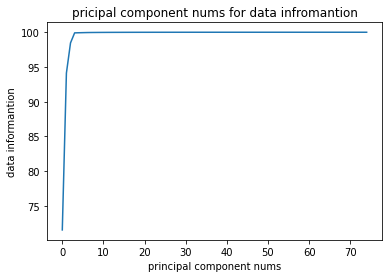

In [6]:
#用PCA看看结果
from sklearn.decomposition import PCA
pca = PCA(random_state=17)
#pca.fit(X_test_scaled)
pca.fit(df_for_test_x)


#pca_result = pca.transform(X_test_scaled)
pca_result = pca.transform(df_for_test_x)
pca_result.shape
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('principal component nums')
plt.ylabel('data informantion')
plt.title('pricipal component nums for data infromantion')

/home/ml/.conda/envs/driver/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/ml/.conda/envs/driver/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


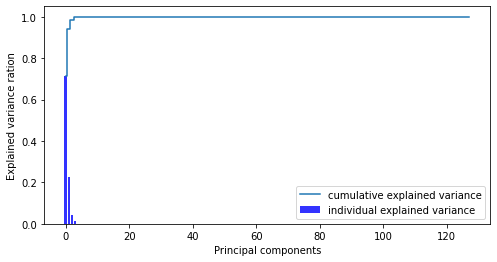

In [7]:
#计算特征值和特征向量
import numpy as np
cov_mat = np.cov(df_for_test_x.astype(np.float32).T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
#print('\n Eigenvalues \n %s' % eigen_vals)
#计算方差贡献率
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.bar(range(0, 128), var_exp, alpha=0.8, align='center', color='blue',label='individual explained variance')
plt.step(range(0, 128), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ration')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

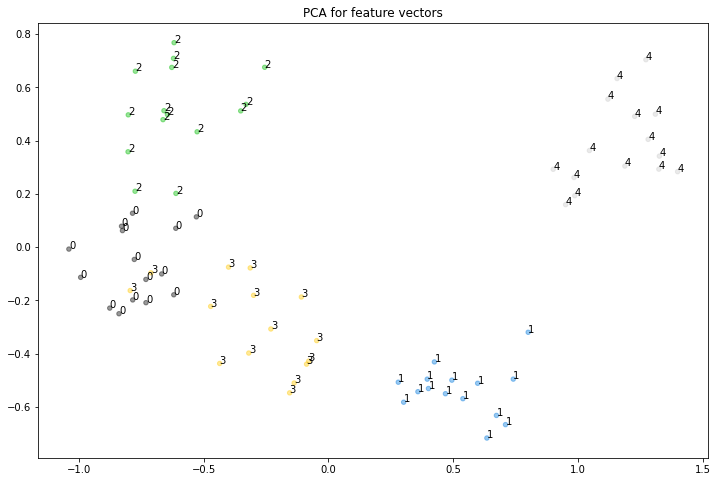

In [8]:
#显示区分效果
plt.figure(figsize=(12,8))
plt.scatter(pca_result[:,0], pca_result[:,1], c=df_for_test_y, s=20, cmap='nipy_spectral', alpha=0.4)
plt.title('PCA for feature vectors')
for i,txt in enumerate(df_for_test_y):
    plt.annotate(txt,(pca_result[i,0],pca_result[i,1]))
plt.show()

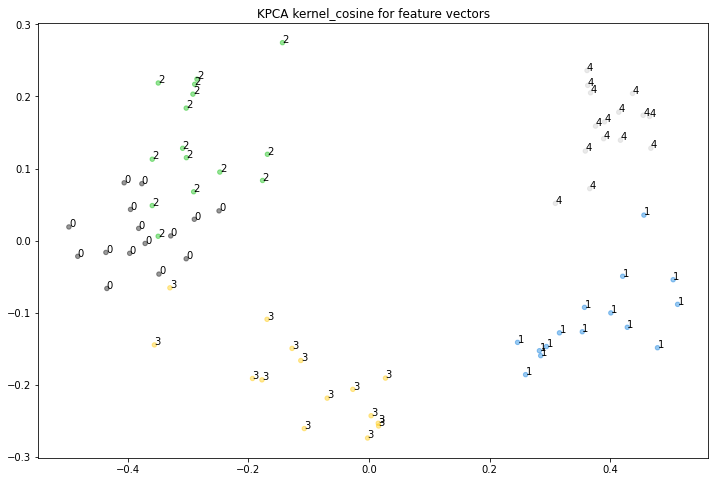

In [11]:
from sklearn.decomposition import KernelPCA

kernel_choose = 'cosine'
#kernel_choose = 'rbf'
    
pca = KernelPCA(random_state=17,kernel=kernel_choose)
pca.fit(df_for_test_x)

pca_result = pca.transform(df_for_test_x)
pca_result.shape

#显示区分效果
plt.figure(figsize=(12,8))
plt.scatter(pca_result[:,0], pca_result[:,1], c=df_for_test_y, s=20, cmap='nipy_spectral', alpha=0.4)
#plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.title('KPCA kernel_' + kernel_choose+ ' for feature vectors')
for i,txt in enumerate(df_for_test_y):
    plt.annotate(txt,(pca_result[i,0],pca_result[i,1]))
plt.show()

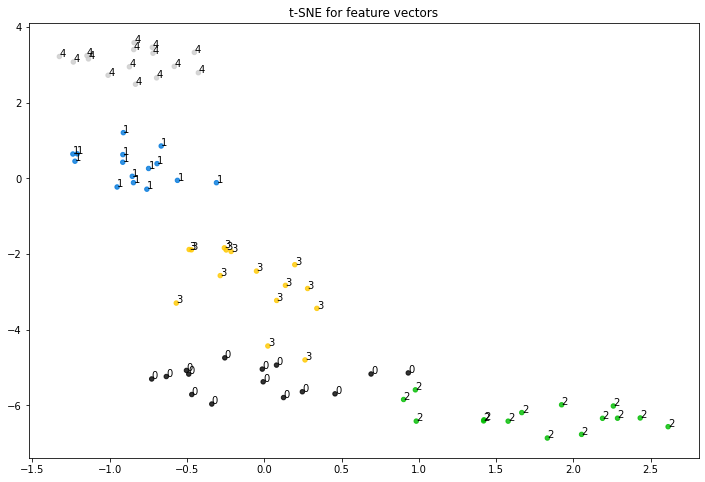

In [12]:
#用T-SNE看看区分效果
from sklearn.manifold import TSNE
tsne = TSNE(random_state=23,learning_rate=100)
#tsne_representation = tsne.fit_transform(X_test_scaled, y=df_for_test_y)
tsne_representation = tsne.fit_transform(df_for_test_x, y=df_for_test_y)

plt.figure(figsize=(12,8))
#plt.scatter(tsne_representation[:,0], tsne_representation[:,1], c=df['target'], s=5, cmap='viridis_r', alpha=.8)
#plt.scatter(tsne_representation[:,0], tsne_representation[:,1], c=df['target'][0:1600], s=5, cmap='viridis_r', alpha=.8)
plt.scatter(tsne_representation[:,0], tsne_representation[:,1], c=df_for_test_y, s=20, cmap='nipy_spectral', alpha=.8)

plt.title('t-SNE for feature vectors')
for i,txt in enumerate(df_for_test_y):
    plt.annotate(txt,(tsne_representation[i,0],tsne_representation[i,1]))
plt.show() 